# Show sensitivity of magnitude to choice of extreme value distribution 
* Meg Fowler, 2019-06-01

In [1]:
import scipy as scipy
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import random as rand
import multiprocessing
import cartopy
import os.path
from joblib import Parallel, delayed
from scipy.stats import genextreme as gev
from scipy.stats import gumbel_r as gumbel
from netCDF4 import Dataset

## Read in data

In [2]:
CaMaFile = Dataset('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/fldare1161.nc')
# print(CaMaFile.dimensions.keys())|

lat =  CaMaFile.variables['lat'][:] 
lon = CaMaFile.variables['lon'][:] 

In [3]:
matData   = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/control_outflw.mat')
maxYearly = matData['maxYearly_full']

fullData   = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/full_outflw.mat')
fullYearly = fullData['maxYearly_full']

physData = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/physiology_outflw.mat')
physYearly = physData['maxYearly_full']

radData = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/radiation_outflw.mat')
radYearly = radData['maxYearly_full']

## Create functions to compute Gumbel and GEV

In [4]:
def computeGumbel(recArray,recFullArr,recPhysArr,recRadArr,i):
    
    if np.remainder(i,100)==0:
        print(i) 
    
    #print(len(lat))
    
    TfullInt = np.full([len(lat)],np.nan)
    TphysInt = np.full([len(lat)],np.nan)
    TradInt = np.full([len(lat)],np.nan)
    
    for j in range(len(lat)):   

        #print(j)
        rec     = recArray[j,:]
        recFull = recFullArr[j,:]
        recPhys = recPhysArr[j,:]
        recRad  = recRadArr[j,:]
       
        # Check for NaN 
        validCount = np.count_nonzero(~np.isnan(rec))
              
        if validCount>5: 
            #print("Starting to compute...")
            
            gumbel_fit = gumbel.fit(rec)
            M = gumbel_fit[0]
            S = gumbel_fit[1]
    
            #Compute discharge of 100-year flood 
            R100 = gumbel.ppf((1-(1/retPeriod)),loc=M,scale=S)
            # Imagine we have the PDF for the gumbel fit of flood magnitude
            # R100 is the flood magnitude corresopnding to 99% probability i.e.
            # Inverting the CDF at 0.99
            # i.e. 1-CDF = 0.01 (definition of the 100 year flood)
            # Analogous to tinv (0.99,dof) in matlab inversion of t-distribution.
            # So if rec --> 100*rec, R100 --> 100*R100
    
            #Compute fit for CO2 experiments
            gumbelFull = gumbel.fit(recFull)
            gumbelPhys = gumbel.fit(recPhys)
            gumbelRad  = gumbel.fit(recRad)
    
            cdfFull = gumbel.cdf(R100,*gumbelFull)    #Compute CDF at the point of R100 
            cdfPhys = gumbel.cdf(R100,*gumbelPhys)
            cdfRad  = gumbel.cdf(R100,*gumbelRad)
            # Let's suppose the PDF shifts to the right. 
            # Then the same magnitude flood from R100 would be more likely to occur
            # I.e more of the tail is to the right of R100
            # So CDF of the new fitted distribution evaluated at the old R100 will be < 0.99 
            # And 1-CDF is the boost in the tail to the right of R100.
            # It might be more like 4/100 
            # The inverse of that (100/4) says the 100 year flood happens every 25 years.
    
            TfullInt[j] = 1/(1-cdfFull)    #Return Period 
            TphysInt[j] = 1/(1-cdfPhys)
            TradInt[j]  = 1/(1-cdfRad)
            
    Tfull = TfullInt
    Tphys = TphysInt
    Trad  = TradInt
    
    return Tfull, Tphys, Trad

In [11]:
def computeGEV(ctrl,full,phys,rad,i):
    
    if np.remainder(i,100)==0:
        print(i)
    
    # Define empty arrays to save data into
    K    = np.empty([len(lat)])
    M    = np.empty([len(lat)])
    S    = np.empty([len(lat)])
    R100 = np.empty([len(lat)])

    Tfull = np.empty([len(lat)])
    Tphys = np.empty([len(lat)])
    Trad = np.empty([len(lat)])

    j=0
    while j<len(lat):
        
        # Compute GEV fit for CTRL and compute discharge of "retPeriod"-year flood
        rec = ctrl[j,:]
        
        # Check for NaN 
        validCount = np.count_nonzero(~np.isnan(rec))
        
        if validCount>5:
        
            gev_fit = gev.fit(rec)
        
            K[j] = gev_fit[0]
            M[j] = gev_fit[1]
            S[j] = gev_fit[2]
        
            R100[j]=gev.ppf((1-(1/retPeriod)),K[j],loc=M[j],scale=S[j])
        
            # Compute return period of that magnitude flood in 4xCO2 experiments 
            recFull = full[j]
            recPhys = phys[j]
            recRad  = rad[j]
        
            gevFull = gev.fit(recFull)   #Fit GEV to get parameters in each case 
            gevPhys = gev.fit(recPhys)
            gevRad  = gev.fit(recRad)       
        
            cdfFull = gev.cdf(R100[j],*gevFull)    #Compute CDF at the point of R100 
            cdfPhys = gev.cdf(R100[j],*gevPhys)
            cdfRad  = gev.cdf(R100[j],*gevRad)
        
            Tfull[j] = 1/(1-cdfFull)    #Return Period 
            Tphys[j] = 1/(1-cdfPhys)
            Trad[j] = 1/(1-cdfRad)
            
        j = j+1
    
    Tfull_ret = Tfull
    Tphys_ret = Tphys
    Trad_ret  = Trad
    
    return Tfull_ret,Tphys_ret,Trad_ret
    

In [6]:
# -- Compute Gumbel based flood return period -- #

Tfull_Gumbel = np.full([len(lon),len(lat)],np.nan)
Tphys_Gumbel = np.full([len(lon),len(lat)],np.nan)
Trad_Gumbel  = np.full([len(lon),len(lat)],np.nan)

rec     = maxYearly
recFull = fullYearly
recPhys = physYearly
recRad  = radYearly

retPeriod = 100.0  #Return period

Tbig = Parallel(n_jobs=10)(delayed(computeGumbel)(rec[i,:,:],recFull[i,:,:],recPhys[i,:,:],recRad[i,:,:],i) for i in range(len(lon)))

for i in range(len(Tbig)):
    Tfull_Gumbel[i,:] = Tbig[i][0]
    Tphys_Gumbel[i,:] = Tbig[i][1]
    Trad_Gumbel[i,:]  = Tbig[i][2]


0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars


100


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars


200


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_

300


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


400


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_

500
600
700
800
900
1000
1100
1200
1300
1400


In [12]:
# -- Compute GEV based flood return period --- #

Tfull_GEV = np.full([len(lon),len(lat)],np.nan)
Tphys_GEV = np.full([len(lon),len(lat)],np.nan)
Trad_GEV  = np.full([len(lon),len(lat)],np.nan)

rec     = maxYearly
recFull = fullYearly
recPhys = physYearly
recRad  = radYearly

retPeriod = 100.0  #Return period

Tbig = Parallel(n_jobs=10)(delayed(computeGEV)(rec[i,:,:],recFull[i,:,:],recPhys[i,:,:],recRad[i,:,:],i) for i in range(len(lon)))

for i in range(len(Tbig)):
    Tfull_GEV[i,:] = Tbig[i][0]
    Tphys_GEV[i,:] = Tbig[i][1]
    Trad_GEV[i,:]  = Tbig[i][2]


0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered i

100
200


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


300


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


400
500
600
700
800


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


900


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


1000
1100
1200
1300
1400


## Plot the two flood return period maps

In [13]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

### Create a list of RGB tuples
colorsList = [(27,30,72), (62,86,170), (81,144,208), (104,200,220),(166,227,221), 
           (221,238,247), (248,247,100),(250,203,0),(249,81,1), (246,80,149),(242,30,15)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap = make_cmap(colorsList, bit=True)

<br><br>*GEV Fit first*<br><br>

In [33]:
#Create mask of where the calculation was actually valid for GEV... 
#  Based on same critera as in function, but originally made array with 'empty' instead of filled with NaNs. 

mask1 = np.full([len(lon),len(lat)],np.nan)

mask1[np.where(np.isfinite(rec[:,:,0]))] = 1

# for ilon in range(len(lon)):
#     for ilat in range(len(lat)):
#         # Check for NaN 
#         validCount = np.count_nonzero(~np.isnan(rec))
        
#         if validCount>5: 
#             mask1[ilon,ilat] = 1 


In [14]:
# Define array of colors for maps
TfullGEV_col = Tfull_GEV
TradGEV_col  = Trad_GEV
TphysGEV_col = Tphys_GEV 

colorsFull_GEV = np.full([len(lon),len(lat)],np.nan)
colorsFull_GEV[np.where((TfullGEV_col>=2)  & (TfullGEV_col<=5))]     = 1
colorsFull_GEV[np.where((TfullGEV_col>5)   & (TfullGEV_col<=25))]    = 2
colorsFull_GEV[np.where((TfullGEV_col>25)  & (TfullGEV_col<=50))]    = 3
colorsFull_GEV[np.where((TfullGEV_col>50)  & (TfullGEV_col<=75))]    = 4
colorsFull_GEV[np.where((TfullGEV_col>75)  & (TfullGEV_col<=95))]    = 5
colorsFull_GEV[np.where((TfullGEV_col>95)  & (TfullGEV_col<=105))]   = 6
colorsFull_GEV[np.where((TfullGEV_col>105) & (TfullGEV_col<=125))]   = 7
colorsFull_GEV[np.where((TfullGEV_col>125) & (TfullGEV_col<=250))]   = 8
colorsFull_GEV[np.where((TfullGEV_col>250) & (TfullGEV_col<=500))]   = 9
colorsFull_GEV[np.where((TfullGEV_col>500) & (TfullGEV_col<=1000))]  = 10
colorsFull_GEV[np.where(TfullGEV_col>1000)]                       = 11

colorsRad_GEV = np.full([len(lon),len(lat)],np.nan)
colorsRad_GEV[np.where((TradGEV_col>=2)  & (TradGEV_col<=5))]     = 1
colorsRad_GEV[np.where((TradGEV_col>5)   & (TradGEV_col<=25))]    = 2
colorsRad_GEV[np.where((TradGEV_col>25)  & (TradGEV_col<=50))]    = 3
colorsRad_GEV[np.where((TradGEV_col>50)  & (TradGEV_col<=75))]    = 4
colorsRad_GEV[np.where((TradGEV_col>75)  & (TradGEV_col<=95))]    = 5
colorsRad_GEV[np.where((TradGEV_col>95)  & (TradGEV_col<=105))]   = 6
colorsRad_GEV[np.where((TradGEV_col>105) & (TradGEV_col<=125))]   = 7
colorsRad_GEV[np.where((TradGEV_col>125) & (TradGEV_col<=250))]   = 8
colorsRad_GEV[np.where((TradGEV_col>250) & (TradGEV_col<=500))]   = 9
colorsRad_GEV[np.where((TradGEV_col>500) & (TradGEV_col<=1000))]  = 10
colorsRad_GEV[np.where(TradGEV_col>1000)]                      = 11

colorsPhys_GEV = np.full([len(lon),len(lat)],np.nan)
colorsPhys_GEV[np.where((TphysGEV_col>=2)  & (TphysGEV_col<=5))]     = 1
colorsPhys_GEV[np.where((TphysGEV_col>5)   & (TphysGEV_col<=25))]    = 2
colorsPhys_GEV[np.where((TphysGEV_col>25)  & (TphysGEV_col<=50))]    = 3
colorsPhys_GEV[np.where((TphysGEV_col>50)  & (TphysGEV_col<=75))]    = 4
colorsPhys_GEV[np.where((TphysGEV_col>75)  & (TphysGEV_col<=95))]    = 5
colorsPhys_GEV[np.where((TphysGEV_col>95)  & (TphysGEV_col<=105))]   = 6
colorsPhys_GEV[np.where((TphysGEV_col>105) & (TphysGEV_col<=125))]   = 7
colorsPhys_GEV[np.where((TphysGEV_col>125) & (TphysGEV_col<=250))]   = 8
colorsPhys_GEV[np.where((TphysGEV_col>250) & (TphysGEV_col<=500))]   = 9
colorsPhys_GEV[np.where((TphysGEV_col>500) & (TphysGEV_col<=1000))]  = 10
colorsPhys_GEV[np.where(TphysGEV_col>1000)]                       = 11

/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: Ru

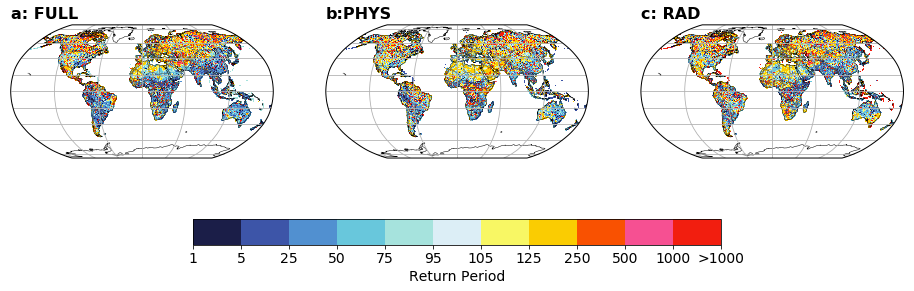

In [43]:
fig = plt.figure()

ax1 = fig.add_subplot(131,projection=ccrs.Robinson())
ax2 = fig.add_subplot(132,projection=ccrs.Robinson())
ax3 = fig.add_subplot(133,projection=ccrs.Robinson())

fig.set_size_inches(16,12)
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm   = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig.subplots_adjust(wspace=0,hspace=0.18)

## Subplot 1: TFULL
colorsFullT_GEV = np.transpose(colorsFull_GEV*mask1)
contour_plot = ax1.pcolormesh(lon,lat,colorsFullT_GEV,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax1.set_title('a: FULL',{'fontweight' :'bold','fontsize':16},loc='left')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


## Subplot 2: TPHYS
colorsPhysT_GEV = np.transpose(colorsPhys_GEV*mask1)
contour_plot = ax2.pcolormesh(lon,lat,colorsPhysT_GEV,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
# Colorbar
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0+0.2, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=14)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=14)  # vertically oriented colorbar
#Additional options 
ax2.set_title('b:PHYS',{'fontweight' :'bold','fontsize':16},loc='left')
ax2.title.set_fontsize(16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

## Subplot 3: TRAD
colorsRadT_GEV = np.transpose(colorsRad_GEV*mask1)
contour_plot = ax3.pcolormesh(lon,lat,colorsRadT_GEV,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax3.set_title('c: RAD',{'fontweight' :'bold','fontsize':16},loc='left')
ax3.title.set_fontsize(16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

fig.subplots_adjust(wspace=0.2, hspace=0.01)


*NEXT: Gumbel Distribution*<br><br>

In [44]:
# Define array of colors for maps
TfullGumbel_col = Tfull_Gumbel
TradGumbel_col  = Trad_Gumbel
TphysGumbel_col = Tphys_Gumbel

colorsFull_Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsFull_Gumbel[np.where((TfullGumbel_col>=2)  & (TfullGumbel_col<=5))]     = 1
colorsFull_Gumbel[np.where((TfullGumbel_col>5)   & (TfullGumbel_col<=25))]    = 2
colorsFull_Gumbel[np.where((TfullGumbel_col>25)  & (TfullGumbel_col<=50))]    = 3
colorsFull_Gumbel[np.where((TfullGumbel_col>50)  & (TfullGumbel_col<=75))]    = 4
colorsFull_Gumbel[np.where((TfullGumbel_col>75)  & (TfullGumbel_col<=95))]    = 5
colorsFull_Gumbel[np.where((TfullGumbel_col>95)  & (TfullGumbel_col<=105))]   = 6
colorsFull_Gumbel[np.where((TfullGumbel_col>105) & (TfullGumbel_col<=125))]   = 7
colorsFull_Gumbel[np.where((TfullGumbel_col>125) & (TfullGumbel_col<=250))]   = 8
colorsFull_Gumbel[np.where((TfullGumbel_col>250) & (TfullGumbel_col<=500))]   = 9
colorsFull_Gumbel[np.where((TfullGumbel_col>500) & (TfullGumbel_col<=1000))]  = 10
colorsFull_Gumbel[np.where(TfullGumbel_col>1000)]                       = 11

colorsRad_Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsRad_Gumbel[np.where((TradGumbel_col>=2)  & (TradGumbel_col<=5))]     = 1
colorsRad_Gumbel[np.where((TradGumbel_col>5)   & (TradGumbel_col<=25))]    = 2
colorsRad_Gumbel[np.where((TradGumbel_col>25)  & (TradGumbel_col<=50))]    = 3
colorsRad_Gumbel[np.where((TradGumbel_col>50)  & (TradGumbel_col<=75))]    = 4
colorsRad_Gumbel[np.where((TradGumbel_col>75)  & (TradGumbel_col<=95))]    = 5
colorsRad_Gumbel[np.where((TradGumbel_col>95)  & (TradGumbel_col<=105))]   = 6
colorsRad_Gumbel[np.where((TradGumbel_col>105) & (TradGumbel_col<=125))]   = 7
colorsRad_Gumbel[np.where((TradGumbel_col>125) & (TradGumbel_col<=250))]   = 8
colorsRad_Gumbel[np.where((TradGumbel_col>250) & (TradGumbel_col<=500))]   = 9
colorsRad_Gumbel[np.where((TradGumbel_col>500) & (TradGumbel_col<=1000))]  = 10
colorsRad_Gumbel[np.where(TradGumbel_col>1000)]                      = 11

colorsPhys_Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsPhys_Gumbel[np.where((TphysGumbel_col>=2)  & (TphysGumbel_col<=5))]     = 1
colorsPhys_Gumbel[np.where((TphysGumbel_col>5)   & (TphysGumbel_col<=25))]    = 2
colorsPhys_Gumbel[np.where((TphysGumbel_col>25)  & (TphysGumbel_col<=50))]    = 3
colorsPhys_Gumbel[np.where((TphysGumbel_col>50)  & (TphysGumbel_col<=75))]    = 4
colorsPhys_Gumbel[np.where((TphysGumbel_col>75)  & (TphysGumbel_col<=95))]    = 5
colorsPhys_Gumbel[np.where((TphysGumbel_col>95)  & (TphysGumbel_col<=105))]   = 6
colorsPhys_Gumbel[np.where((TphysGumbel_col>105) & (TphysGumbel_col<=125))]   = 7
colorsPhys_Gumbel[np.where((TphysGumbel_col>125) & (TphysGumbel_col<=250))]   = 8
colorsPhys_Gumbel[np.where((TphysGumbel_col>250) & (TphysGumbel_col<=500))]   = 9
colorsPhys_Gumbel[np.where((TphysGumbel_col>500) & (TphysGumbel_col<=1000))]  = 10
colorsPhys_Gumbel[np.where(TphysGumbel_col>1000)]                       = 11

/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: Ru

In [ ]:
# -- Try new color ranges to see if we can get same plot or similar? -- #

# Define array of colors for maps
TfullGumbel_col = Tfull_Gumbel
TradGumbel_col  = Trad_Gumbel
TphysGumbel_col = Tphys_Gumbel

colorsFull_Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsFull_Gumbel[np.where((TfullGumbel_col>=2)  & (TfullGumbel_col<=5))]     = 1
colorsFull_Gumbel[np.where((TfullGumbel_col>5)   & (TfullGumbel_col<=25))]    = 2
colorsFull_Gumbel[np.where((TfullGumbel_col>25)  & (TfullGumbel_col<=50))]    = 3
colorsFull_Gumbel[np.where((TfullGumbel_col>50)  & (TfullGumbel_col<=75))]    = 4
colorsFull_Gumbel[np.where((TfullGumbel_col>75)  & (TfullGumbel_col<=95))]    = 5
colorsFull_Gumbel[np.where((TfullGumbel_col>95)  & (TfullGumbel_col<=105))]   = 6
colorsFull_Gumbel[np.where((TfullGumbel_col>105) & (TfullGumbel_col<=125))]   = 7
colorsFull_Gumbel[np.where((TfullGumbel_col>125) & (TfullGumbel_col<=250))]   = 8
colorsFull_Gumbel[np.where((TfullGumbel_col>250) & (TfullGumbel_col<=500))]   = 9
colorsFull_Gumbel[np.where((TfullGumbel_col>500) & (TfullGumbel_col<=1000))]  = 10
colorsFull_Gumbel[np.where(TfullGumbel_col>1000)]                       = 11

colorsRad_Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsRad_Gumbel[np.where((TradGumbel_col>=2)  & (TradGumbel_col<=5))]     = 1
colorsRad_Gumbel[np.where((TradGumbel_col>5)   & (TradGumbel_col<=25))]    = 2
colorsRad_Gumbel[np.where((TradGumbel_col>25)  & (TradGumbel_col<=50))]    = 3
colorsRad_Gumbel[np.where((TradGumbel_col>50)  & (TradGumbel_col<=75))]    = 4
colorsRad_Gumbel[np.where((TradGumbel_col>75)  & (TradGumbel_col<=95))]    = 5
colorsRad_Gumbel[np.where((TradGumbel_col>95)  & (TradGumbel_col<=105))]   = 6
colorsRad_Gumbel[np.where((TradGumbel_col>105) & (TradGumbel_col<=125))]   = 7
colorsRad_Gumbel[np.where((TradGumbel_col>125) & (TradGumbel_col<=250))]   = 8
colorsRad_Gumbel[np.where((TradGumbel_col>250) & (TradGumbel_col<=500))]   = 9
colorsRad_Gumbel[np.where((TradGumbel_col>500) & (TradGumbel_col<=1000))]  = 10
colorsRad_Gumbel[np.where(TradGumbel_col>1000)]                      = 11

colorsPhys_Gumbel = np.full([len(lon),len(lat)],np.nan)
colorsPhys_Gumbel[np.where((TphysGumbel_col>=2)  & (TphysGumbel_col<=5))]     = 1
colorsPhys_Gumbel[np.where((TphysGumbel_col>5)   & (TphysGumbel_col<=25))]    = 2
colorsPhys_Gumbel[np.where((TphysGumbel_col>25)  & (TphysGumbel_col<=50))]    = 3
colorsPhys_Gumbel[np.where((TphysGumbel_col>50)  & (TphysGumbel_col<=75))]    = 4
colorsPhys_Gumbel[np.where((TphysGumbel_col>75)  & (TphysGumbel_col<=95))]    = 5
colorsPhys_Gumbel[np.where((TphysGumbel_col>95)  & (TphysGumbel_col<=105))]   = 6
colorsPhys_Gumbel[np.where((TphysGumbel_col>105) & (TphysGumbel_col<=125))]   = 7
colorsPhys_Gumbel[np.where((TphysGumbel_col>125) & (TphysGumbel_col<=250))]   = 8
colorsPhys_Gumbel[np.where((TphysGumbel_col>250) & (TphysGumbel_col<=500))]   = 9
colorsPhys_Gumbel[np.where((TphysGumbel_col>500) & (TphysGumbel_col<=1000))]  = 10
colorsPhys_Gumbel[np.where(TphysGumbel_col>1000)]                       = 11

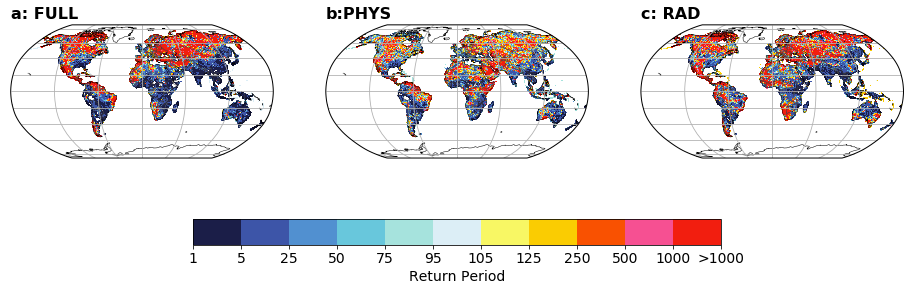

In [45]:
fig = plt.figure()

ax1 = fig.add_subplot(131,projection=ccrs.Robinson())
ax2 = fig.add_subplot(132,projection=ccrs.Robinson())
ax3 = fig.add_subplot(133,projection=ccrs.Robinson())

fig.set_size_inches(16,12)
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm   = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig.subplots_adjust(wspace=0,hspace=0.18)

## Subplot 1: TFULL
colorsFullT_Gumbel = np.transpose(colorsFull_Gumbel*mask1)
contour_plot = ax1.pcolormesh(lon,lat,colorsFullT_Gumbel,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax1.set_title('a: FULL',{'fontweight' :'bold','fontsize':16},loc='left')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


## Subplot 2: TPHYS
colorsPhysT_Gumbel = np.transpose(colorsPhys_Gumbel*mask1)
contour_plot = ax2.pcolormesh(lon,lat,colorsPhysT_Gumbel,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
# Colorbar
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0+0.2, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Return Period',fontsize=14)
cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=14)  # vertically oriented colorbar
#Additional options 
ax2.set_title('b:PHYS',{'fontweight' :'bold','fontsize':16},loc='left')
ax2.title.set_fontsize(16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

## Subplot 3: TRAD
colorsRadT_Gumbel = np.transpose(colorsRad_Gumbel*mask1)
contour_plot = ax3.pcolormesh(lon,lat,colorsRadT_Gumbel,norm=norm,cmap=my_cmap,vmin=1,vmax=12,transform=ccrs.PlateCarree())
#Additional options 
ax3.set_title('c: RAD',{'fontweight' :'bold','fontsize':16},loc='left')
ax3.title.set_fontsize(16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

fig.subplots_adjust(wspace=0.2, hspace=0.01)

